In [3]:
import sys
import os
from pathlib import Path
sys.path.insert(0, (str(Path().resolve())))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lib import (
    load_gemma, get_layer_range, patch_and_query,
    MultiGPUWorkerPool, precompute_activations, grid_sweep_hyperparam_parallel
)

In [3]:
from dotenv import load_dotenv
load_dotenv()
from huggingface_hub import login
login(token=os.getenv("HUGGINGFACE_HUB_TOKEN"))

# Load one model per GPU
pool = MultiGPUWorkerPool()
N_LAYERS = pool.models[0].config.num_hidden_layers
print(f"Loaded {pool.n_gpus} Gemma-3-1b-it models with {N_LAYERS} layers each")

[POOL] Loading models on 8 GPUs (compile disabled for thread safety)...


`torch_dtype` is deprecated! Use `dtype` instead!


[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 0 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 1 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 2 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 3 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 4 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 5 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 6 ready
[MODEL] Flash Attention not installed, using SDPA
[POOL] GPU 7 ready
[POOL] All 8 models loaded
Loaded 8 Gemma-3-1b-it models with 26 layers each


In [4]:
import yaml
import re
from tqdm.auto import tqdm

yaml_path = Path("cotgeom/sentiment_examples.yaml")
if not yaml_path.exists():
    yaml_path = Path("sentiment_examples.yaml")

with open(yaml_path) as f:
    data = yaml.safe_load(f)

pos_examples = data["positive"]
neg_examples = data["negative"]
print(f"Loaded {len(pos_examples)} positive, {len(neg_examples)} negative examples")

Loaded 25 positive, 25 negative examples


In [5]:
# Precompute activations using first GPU's model
model, tokenizer = pool.models[0], pool.tokenizers[0]

cached_pos = precompute_activations(model, tokenizer, pos_examples)
cached_neg = precompute_activations(model, tokenizer, neg_examples)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[CACHE] Extracting activations for 25 texts, layers 0-25...
[CACHE] Done. Cached 25 activation sets.
[CACHE] Extracting activations for 25 texts, layers 0-25...
[CACHE] Done. Cached 25 activation sets.


In [6]:
def parse_yes_no(response: str) -> bool | None:
    """Extract yes/no from response, ignoring the question part."""
    r = response.lower()
    
    # Try to find answer after common patterns
    for marker in ["answer yes or no.", "yes or no.", "\n\n"]:
        if marker in r:
            r = r.split(marker)[-1]
            break
    
    if re.search(r'\byes\b', r): return True
    if re.search(r'\bno\b', r): return False
    return None

def evaluate(frac_layers: float, frac_tokens: float, alpha: float, n_examples: int = None, pbar=None) -> float:
    """Evaluate accuracy. n_examples limits how many per class (None = all)."""
    pos = pos_examples[:n_examples] if n_examples else pos_examples
    neg = neg_examples[:n_examples] if n_examples else neg_examples
    
    correct = 0
    total = len(pos) + len(neg)
    q = "Is this text expressing positive sentiment? Answer yes or no."
    
    for text in pos:
        resp = patch_and_query(model, tokenizer, text, q, 
                               frac_patch_layers=frac_layers,
                               frac_patch_tokens=frac_tokens,
                               alpha=alpha, debug=False)
        if parse_yes_no(resp) == True:
            correct += 1
        if pbar: pbar.update(1)
    
    for text in neg:
        resp = patch_and_query(model, tokenizer, text, q,
                               frac_patch_layers=frac_layers,
                               frac_patch_tokens=frac_tokens,
                               alpha=alpha, debug=False)
        if parse_yes_no(resp) == False:
            correct += 1
        if pbar: pbar.update(1)
    
    return correct / total

In [7]:
# Debug: test a few examples and print outputs
q = "Is this text expressing positive sentiment? Answer yes or no."

print("=== POSITIVE EXAMPLES (alpha=0.5) ===")
for text in pos_examples[:2]:
    resp = patch_and_query(model, tokenizer, text, q, frac_patch_layers=0.5, alpha=0.5, debug=True)
    print(f"Text: {text[:50]}...")
    print(f"Response: {resp}")
    print(f"Parsed: {parse_yes_no(resp)}")
    print()

print("=== NEGATIVE EXAMPLES (alpha=0.5) ===")
for text in neg_examples[:2]:
    resp = patch_and_query(model, tokenizer, text, q, frac_patch_layers=0.5, alpha=0.5, debug=True)
    print(f"Text: {text[:50]}...")
    print(f"Response: {resp}")
    print(f"Parsed: {parse_yes_no(resp)}")
    print()

print("\n" + "="*60)
print("=== TRYING alpha=1.0 (full replacement) ===")
print("="*60 + "\n")

print("=== POSITIVE (alpha=1.0) ===")
for text in pos_examples[:2]:
    resp = patch_and_query(model, tokenizer, text, q, frac_patch_layers=0.5, alpha=1.0, debug=True)
    print(f"Text: {text[:50]}...")
    print(f"Response: {resp}")
    print(f"Parsed: {parse_yes_no(resp)}")
    print()

print("=== NEGATIVE (alpha=1.0) ===")
for text in neg_examples[:2]:
    resp = patch_and_query(model, tokenizer, text, q, frac_patch_layers=0.5, alpha=1.0, debug=True)
    print(f"Text: {text[:50]}...")
    print(f"Response: {resp}")
    print(f"Parsed: {parse_yes_no(resp)}")
    print()

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


=== POSITIVE EXAMPLES (alpha=0.5) ===
[SETUP] n_patch=11, patch_layers=13-25
  Input shape: torch.Size([1, 24]), patch_positions: [1, 2, 3, 4, 5]...
[INJECT] Layer 13: seq_len=24, 11 positions
  pos=1: norm 4544.0 → 28160.0
[INJECT] Layer 14: seq_len=24, 11 positions
  pos=1: norm 29952.0 → 41984.0
[INJECT] Layer 15: seq_len=24, 11 positions
  pos=1: norm 43264.0 → 49152.0
[INJECT] Layer 16: seq_len=24, 11 positions
  pos=1: norm 50944.0 → 54016.0
[INJECT] Layer 17: seq_len=24, 11 positions
  pos=1: norm 55552.0 → 57088.0
[INJECT] Layer 18: seq_len=24, 11 positions
  pos=1: norm 57600.0 → 58368.0
[INJECT] Layer 19: seq_len=24, 11 positions
  pos=1: norm 58880.0 → 59392.0
[INJECT] Layer 20: seq_len=24, 11 positions
  pos=1: norm 58112.0 → 58368.0
[INJECT] Layer 21: seq_len=24, 11 positions
  pos=1: norm 58880.0 → 58880.0
[INJECT] Layer 22: seq_len=24, 11 positions
  pos=1: norm 60928.0 → 60928.0
[INJECT] Layer 23: seq_len=24, 11 positions
  pos=1: norm 55296.0 → 55296.0
[INJECT] Layer 2

In [8]:
# Grid sweep: frac_tokens (x) x frac_layers (y), one plot per alpha
FRAC_TOKENS = np.linspace(.1, 1., 7)
FRAC_LAYERS = np.linspace(.1, 1., 7)
ALPHAS = np.linspace(.0, 1., 5)
N_EXAMPLES = None  # Per class (None = use all)

q = "Is this text expressing positive sentiment? Answer yes or no."

# Run parallel grid sweep across GPUs
results = grid_sweep_hyperparam_parallel(
    pool,
    cached_pos, cached_neg,
    question=q,
    parse_fn=parse_yes_no,
    frac_layers_values=FRAC_LAYERS.tolist(),
    frac_tokens_values=FRAC_TOKENS.tolist(),
    alpha_values=ALPHAS.tolist(),
    n_examples=N_EXAMPLES,
)

# Convert results dict to acc_grids format for plotting
acc_grids = {alpha: np.zeros((len(FRAC_LAYERS), len(FRAC_TOKENS))) for alpha in ALPHAS}
for (alpha, fl, ft), acc in results.items():
    i = np.where(np.isclose(FRAC_LAYERS, fl))[0][0]
    j = np.where(np.isclose(FRAC_TOKENS, ft))[0][0]
    acc_grids[alpha][i, j] = acc

[SWEEP] Evaluating 245 hyperparameter combinations across 8 GPUs...
[SWEEP] Pre-copying activations to 8 GPUs...
[SWEEP] Activations copied, starting sweep...


Grid sweep:   0%|          | 0/245 [00:00<?, ?it/s]

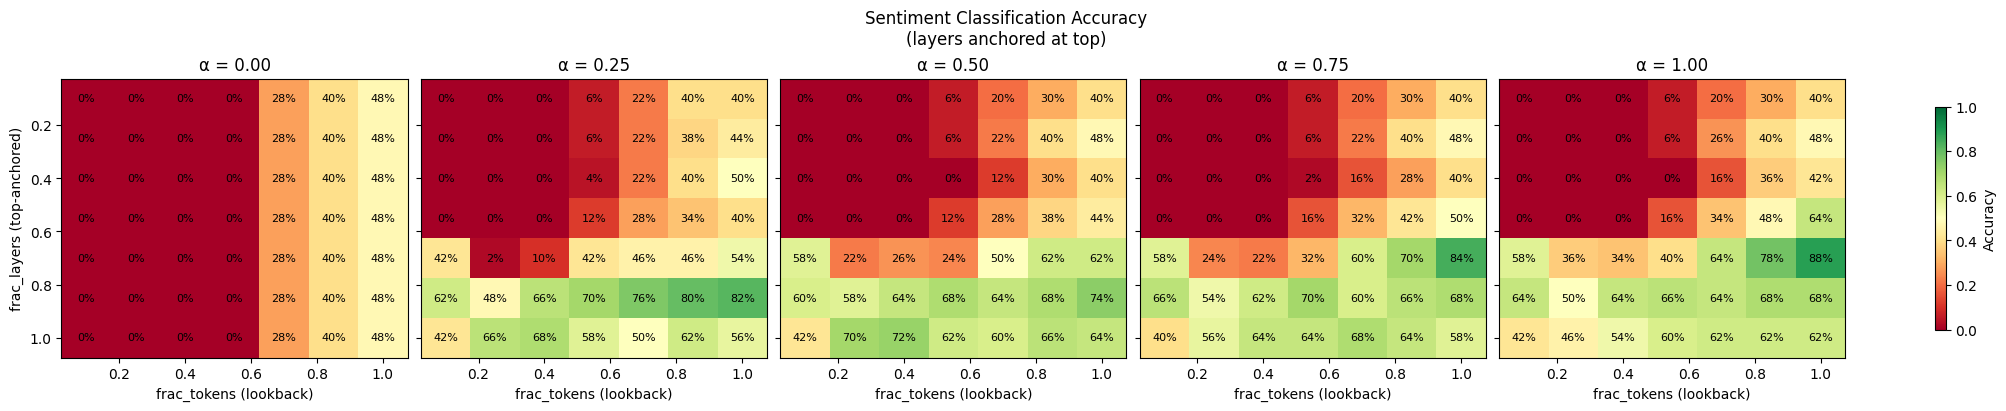

In [9]:
# Plot accuracy heatmaps - one per alpha
n_alphas = len(ALPHAS)
fig, axes = plt.subplots(1, n_alphas, figsize=(4*n_alphas, 4), sharey=True, layout='constrained')

for ax, alpha in zip(axes, ALPHAS):
    acc_grid = acc_grids[alpha]
    im = ax.pcolormesh(FRAC_TOKENS, FRAC_LAYERS, acc_grid, cmap='RdYlGn', vmin=0, vmax=1)
    ax.set_xlabel('frac_tokens (lookback)')
    ax.set_title(f'α = {alpha:.2f}')
    
    # Add text annotations
    for i, fl in enumerate(FRAC_LAYERS):
        for j, ft in enumerate(FRAC_TOKENS):
            start, end, _ = get_layer_range(N_LAYERS, fl)
            ax.text(ft, fl, f'{acc_grid[i,j]:.0%}', ha='center', va='center', fontsize=8, color='black')

axes[0].set_ylabel('frac_layers (top-anchored)')

for ax in axes:
    ax.invert_yaxis()


# Add shared colorbar
fig.colorbar(im, ax=axes, label='Accuracy', shrink=0.8)
fig.suptitle('Sentiment Classification Accuracy\n(layers anchored at top)', fontsize=12)
plt.savefig('figures/ao_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()